SOME DISCOVERIES ABOUT PCA COMPONENTS

In [1]:
import sys
#sys.path.insert(1, '/home/stefano/Desktop/Stefano/scuola/uni/tesi_magistrale/code/routines')
sys.path.insert(1, '../routines')
from GW_helper import *
import matplotlib.pyplot as plt
from ML_routines import *
from EM_KM import *
import keras
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

Using TensorFlow backend.


In [2]:
N_data = 800
ph_dataset = np.zeros((N_data, 2048))
theta_vector = np.zeros((N_data, 3))
f_max = 1000.
f_low = 20.
f_step = 1e-2
spin_mag_max = .8
K = int((f_max-f_low)/f_step)
LALpars = lal.CreateDict()
approx = lalsim.SimInspiralGetApproximantFromString("IMRPhenomPv2")
N_grid = ph_dataset.shape[1]
freq_to_choose = np.arange(0, K, K/N_grid).astype(int)
m2 = 10.
for i in range(N_data):
    if i%200 == 0 and i != 0:
        print("Generated WF ", i, " of ",theta_vector.shape[0])
    q = 2.#np.random.uniform(1.,5.)
    spin1z = np.random.uniform(-spin_mag_max,spin_mag_max)
    spin2z = .7 #np.random.uniform(-spin_mag_max,spin_mag_max)
    #break
    hptilde, hctilde = lalsim.SimInspiralChooseFDWaveform( #where is its definition and documentation????
            q*m2*lalsim.lal.MSUN_SI, #m1
            m2*lalsim.lal.MSUN_SI, #m2
            0, 0, spin1z, #spin vector 1
            0, 0, spin2z, #spin vector 2
            1e6*lalsim.lal.PC_SI, #distance to source
            0, #inclination
            0, #something I don't know
            0, #longAscNodes
            0, #eccentricity
            0, #meanPerAno
            f_step, # frequency incremental step
            f_low, # lowest value of frequency
            f_max, # highest value of frequency
            f_low, #some reference value of frequency (??)
            LALpars, #some lal dictionary
            approx #approx method for the model
            )
    h = np.array(hptilde.data.data)+1j*np.array(hctilde.data.data) #complex waveform
    theta_vector[i,0] = q
    theta_vector[i,1] = spin1z
    theta_vector[i,2] = spin2z
    temp_ph = (np.unwrap(np.angle(h))[int(f_low/f_step):int(f_max/f_step)].real)[freq_to_choose]
    
        #removing spourious gaps (if present)
    ph_diff = np.concatenate((temp_ph[1:],np.array([temp_ph[-1]]))) - temp_ph
         #looking for big discontinuities in the second half of the grid
    index_max = np.argmax(np.abs(ph_diff[int(N_grid/2):]))+int(N_grid/2) 
    if np.abs(ph_diff[index_max-1]) * np.abs(ph_diff[index_max+1]) < 1e-3:
        temp_ph[index_max:] = temp_ph[index_max-1]
        
        #saving to dataset
    ph_dataset[i,:] = temp_ph

Generated WF  200  of  800
Generated WF  400  of  800
Generated WF  600  of  800


In [4]:
        #saving everything
ph_PCA = PCA_model()
ph_PCA.load_model("../datasets/PCA_std_model.dat")
PCA_dataset = ph_PCA.reduce_data(ph_dataset)
max_ph = np.max(np.abs(PCA_dataset), axis = 0)
max_ph[np.where(max_ph > 100)] /= 10.
PCA_dataset = np.divide(PCA_dataset,max_ph)
#to_save = np.concatenate((theta_vector, PCA_dataset_full_ph), axis = 1)
#np.savetxt("../datasets/GW_std_dataset_s0_full.dat", to_save)

In [5]:
    #creating a new model for clustering in q space
theta_vector_s0 = np.loadtxt("../datasets/PCA_train_theta_s0.dat")
if np.all(theta_vector_s0[:,1] == 0):
	theta_vector_s0 = np.reshape(theta_vector_s0[:,0], (theta_vector_s0.shape[0],1))
PCA_dataset_s0 = np.loadtxt("../datasets/PCA_train_s0.dat")
PCA_dataset_s0 = np.divide(PCA_dataset_s0,max_ph)

    #creating cluster in plane q-PC0
data_s0 = np.concatenate((theta_vector_s0, np.reshape(PCA_dataset_s0[:,0], (PCA_dataset_s0.shape[0],1))), axis = 1)

    #creating model for MoE & doing fitting
N_experts = 160
model = K_means_model(data_s0.shape[1], N_experts, sigma = [.1, 1e-3], fit_sigma = [0])
model.fit(data_s0, N_iter=6)

(160, 2)
Cluster 1 empty
Cluster 2 empty
Cluster 4 empty
Cluster 5 empty
Cluster 7 empty
Cluster 8 empty
Cluster 10 empty
Cluster 11 empty
Cluster 13 empty
Cluster 14 empty
Cluster 16 empty
Cluster 17 empty
Cluster 19 empty
Cluster 22 empty
Cluster 24 empty
Cluster 25 empty
Cluster 27 empty
Cluster 28 empty
Cluster 30 empty
Cluster 31 empty
Cluster 33 empty
Cluster 34 empty
Cluster 36 empty
Cluster 37 empty
Cluster 39 empty
Cluster 40 empty
Cluster 42 empty
Cluster 43 empty
Cluster 45 empty
Cluster 46 empty
Cluster 48 empty
Cluster 51 empty
Cluster 53 empty
Cluster 54 empty
Cluster 56 empty
Cluster 57 empty
Cluster 59 empty
Cluster 60 empty
Cluster 62 empty
Cluster 63 empty
Cluster 65 empty
Cluster 66 empty
Cluster 68 empty
Cluster 71 empty
Cluster 73 empty
Cluster 74 empty
Cluster 76 empty
Cluster 77 empty
Cluster 79 empty
Cluster 80 empty
Cluster 82 empty
Cluster 83 empty
Cluster 85 empty
Cluster 88 empty
Cluster 90 empty
Cluster 91 empty
Cluster 93 empty
Cluster 94 empty
Cluster 96 

[-226.71146476249032,
 -191.99980804752465,
 -186.8659476714113,
 -185.6872339114507,
 -185.41641729483828,
 -185.41053864230463]

<IPython.core.display.Javascript object>


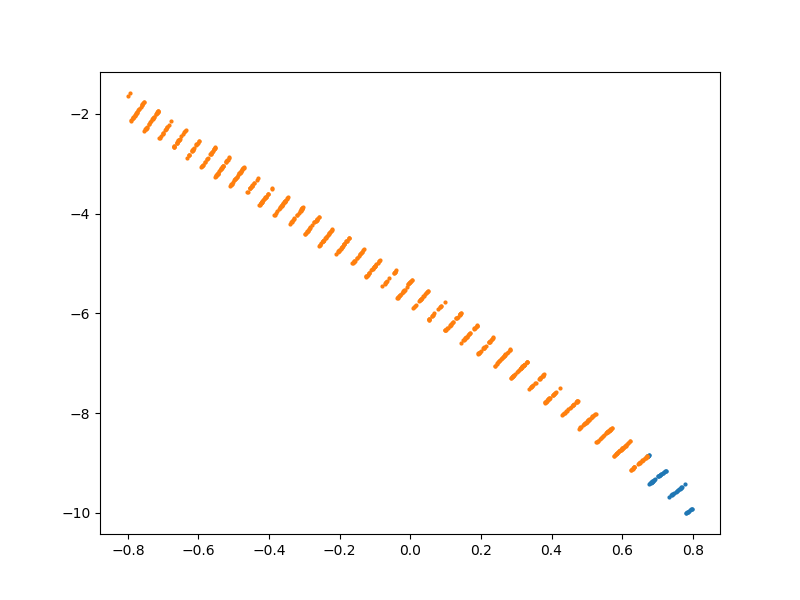

In [7]:
%matplotlib notebook

data= np.vstack((theta_vector[:,1], PCA_dataset[:,0])).T
#print(data.shape,data_s0.shape)
data_labels = model.predict(data, dim_list = [0])

plt.figure(figsize=(8,6))
for k_cl in range(N_experts):
		data_k = data[np.where(data_labels == k_cl)[0]]
		if len(data_k) !=0:
			plt.plot(data_k[:,0], data_k[:,1], 'o', ms = 2)


<IPython.core.display.Javascript object>


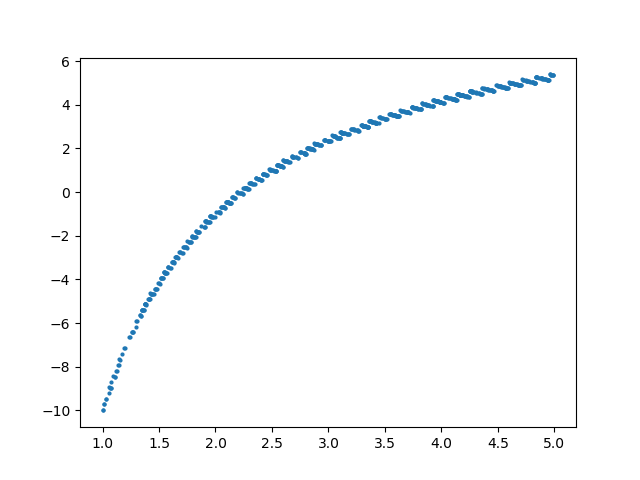

In [14]:
plt.plot(theta_vector[:,0], PCA_dataset[:,0],'o', ms =2)
plt.show()